### Crime in the time of Corona - ETL for Combining FBI Crime and Employment Data into a single dataframe by Year and By State.


In [1]:
## Add dependencies: Pandas
%matplotlib inline
import pandas as pd
import os # needed to use the os.path.join method to load the files
from sqlalchemy import create_engine # for integrating with PostgreSQL
from config import db_password  # for reading postgress db password 
import matplotlib.pyplot as plt # for graphing with Matplotlib

#### FBI Crime Data:  Load raw csv, create dataframe and clean data.

In [2]:
#### FBICrimes Load and Clean the 1980 to 2018 csv data into a dataframe
FBICrimesRaw_df =  pd.read_csv("../Resources/est_crimes_1980_2018_FBI_UCRdata.csv")
FBICrimesRaw_df.head()

,year,state_abbr,population,violent_crime,homicide,rape_legacy,rape_revised,robbery,aggravated_assault
0,1980,AK,440142,1919,39,250.0,NaN,360,1270
1,1980,AL,3861466,17320,509,1158.0,NaN,5102,10551
2,1980,AR,2284037,7656,210,609.0,NaN,1848,4989
3,1980,AZ,2715357,17673,279,1227.0,NaN,5258,10909
4,1980,CA,23532680,210290,3411,13693.0,NaN,90420,102766


In [ ]:
## Check for missing values. 
#  Found 1974 valuesin most columns, except rape_legacy and rape_revised columns. 
# No need to drop anything as we are mostly interested in aggravated_assualt

#FBICrimesRaw_df.count()    
#FBICrimesRaw_df.isnull()  # Confirms Nulls.
#FBICrimesRaw_df.isnull().sum() # Confirms with NULL count

In [ ]:
## Review data types
#  All integers and floats which is good for stats and ML models. Except State with is text.
#  See no need for data conversions.
FBICrimesRaw_df.dtypes

### Create a Crimes by Year Dataframe. 

In [3]:
# FBICrimesByYear_df = FBICrimesRaw_df.groupby('year).sum()
CrimesByYear = FBICrimesRaw_df.groupby('year').sum().reset_index()
CrimesByYear_df=pd.DataFrame(CrimesByYear)
CrimesByYear_df.head(3)

,year,population,violent_crime,homicide,rape_legacy,rape_revised,robbery,aggravated_assault
0,1980,222877773,1335465,22679,82327.0,0.0,563581,666878
1,1981,226616000,1353533,22197,81788.0,0.0,590570,658978
2,1982,228984000,1314381,20654,78051.0,0.0,550976,664700


### Import,inspect and clean the Employment Data

In [4]:
employment_df =  pd.read_csv("../Resources/unemployment_by_state_1980_2018_BLSdata.csv")
employment_df.head(3)

,Year,State,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Yr Avg
0,1980,AK,10.2,10.9,10.8,10.6,9.6,10.2,8.8,8.2,8.5,8.8,9.3,9.6,9.6
1,1981,AK,11.0,11.0,10.3,9.1,8.8,9.5,8.3,8.0,8.4,8.8,9.5,9.9,9.4
2,1982,AK,11.4,11.6,11.1,10.3,9.9,10.1,8.7,8.2,8.6,9.1,10.0,10.3,9.9


In [ ]:
## Check for missing values. 
#  Found 1989 row counts. Nice tight complete database.
# employment_df.count()    
# employment_df.isnull()  # Confirms Nulls.
# employment_df.isnull().sum() # Confirms with NULL count

In [5]:
# Prep for merging. Restrict to year and YrAvg.
employment_yearly_df = employment_df[["Year", "Yr Avg"]].copy()
employment_yearly_df.head(3)

,Year,Yr Avg
0,1980,9.6
1,1981,9.4
2,1982,9.9


In [6]:
# Unemployment by Year Mean across all states
EmploymentYearly = employment_yearly_df.groupby('Year').mean().reset_index()
EmploymentYearly_df=pd.DataFrame(EmploymentYearly)
EmploymentYearly_df.head()

,Year,Yr Avg
0,1980,6.811765
1,1981,7.325490
2,1982,9.217647
3,1983,9.162745
4,1984,7.309804


In [ ]:
## Now we merge the dataframes..
#  Never figured out why this did not work. arggh....
#crimes_employment_df= pd.merge(CrimesByYear_df, EmploymentYearly_df, on=["year","Year"])
#crimes_employment_df.head(3)

In [7]:
## Sweet way to get the dataframes to merge.  
#  For some reason, the normal method in the cell above did not work, so DeShan Yu offered this alternative method.
CrimesEmploymentByYear_df=CrimesByYear_df.copy()
CrimesEmploymentByYear_df["Yr Avg"]=EmploymentYearly_df["Yr Avg"]
CrimesEmploymentByYear_df.head()

,year,population,violent_crime,homicide,rape_legacy,rape_revised,robbery,aggravated_assault,Yr Avg
0,1980,222877773,1335465,22679,82327.0,0.0,563581,666878,6.811765
1,1981,226616000,1353533,22197,81788.0,0.0,590570,658978,7.325490
2,1982,228984000,1314381,20654,78051.0,0.0,550976,664700,9.217647
3,1983,231393000,1250396,19018,78275.0,0.0,504666,648437,9.162745
4,1984,233563000,1265468,18437,83487.0,0.0,483204,680340,7.309804


In [8]:
# rename the "Yr Avg" column to avoid potentialspace in name pitfalls.
CrimesEmploymentByYear_df.rename(columns={"Yr Avg": "emp_rate"}, inplace=True)

#### Exploratory Data Analysis

In [ ]:
## Some Quick Stats
CrimesEmploymentByYear_df.describe() # not really useful

In [ ]:
# Correlation Matrix for preliminary analysis
corrMatrix = CrimesEmploymentByYear_df.corr()
print(corrMatrix)
## Review shows Annual average unemployment rate has a 
# a moderately negative relationship with aggravated assault at -0.439.
# Aggravated assualt does show a weak positive relationship with robbery at 0.21.
# Review suggests a focus on robbery and aggravated assault, along with unemployment of course.
# Violent crime paints an overall picture of crime, and correlates strongly with robbery at 0.82 and aggravated assault at 0.92
# As aggravated assualt tends to capture domestic crime while presumably robbery tends to 
# happen outside the home, so further analysis should focus on comparing violent crime, aggravated assualt and robbery. 
## violent crime, aggravated assualt and robbery. 

In [ ]:
# Review the data types. May need adjustments
CrimesEmploymentByYear_df.dtypes

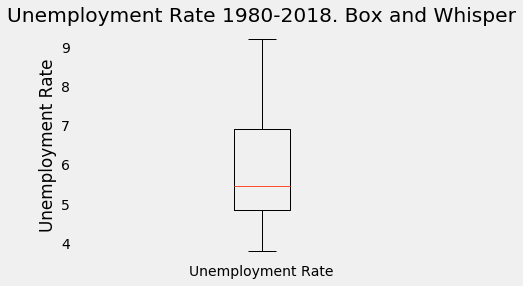

In [49]:
# Create a box-and-whisker plot Unemployment Rate
x_labels = ["Unemployment Rate"]
fig, ax = plt.subplots()
ax.boxplot(CrimesEmploymentByYear_df["emp_rate"], labels=x_labels)
# Add the title, y-axis label and grid.
ax.set_title('Unemployment Rate 1980-2018. Box and Whisper')
ax.set_ylabel('Unemployment Rate')
ax.grid()
plt.show()

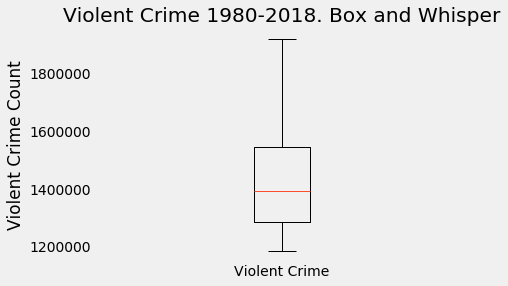

In [48]:
# Create a box-and-whisker plot for Violent Crime. Not really helpful at this point,.
x_labels = ["Violent Crime"]
fig, ax = plt.subplots()
ax.boxplot(CrimesEmploymentByYear_df["violent_crime"], labels=x_labels)
# Add the title, y-axis label and grid.
ax.set_title('Violent Crime 1980-2018. Box and Whisper')
ax.set_ylabel('Violent Crime Count')
ax.grid()
plt.show()

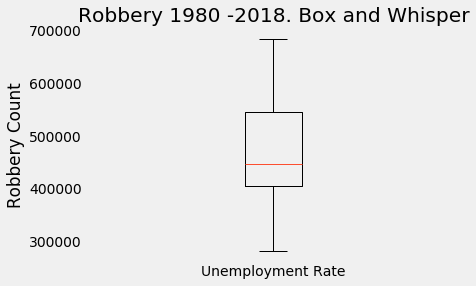

In [51]:
# Create a box-and-whisker plot for Robbery
fig, ax = plt.subplots()
ax.boxplot(CrimesEmploymentByYear_df["robbery"], labels=x_labels)
# Add the title, y-axis label and grid.
ax.set_title('Robbery 1980 -2018. Box and Whisper')
ax.set_ylabel('Robbery Count')
ax.grid()
plt.show()

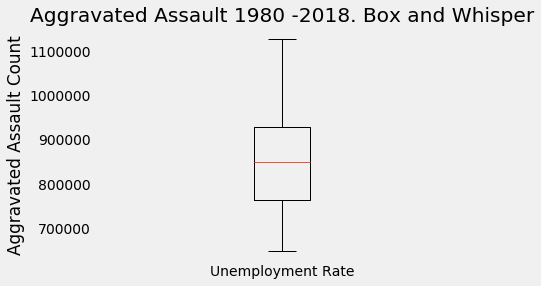

In [54]:
# Create a box-and-whisker plot for Aggravated Assault
fig, ax = plt.subplots()
ax.boxplot(CrimesEmploymentByYear_df["aggravated_assault"], labels=x_labels)
# Add the title, y-axis label and grid.
ax.set_title('Aggravated Assault 1980 -2018. Box and Whisper')
ax.set_ylabel('Aggravated Assault Count')
ax.grid()
plt.show()

### Plot our data of interest

In [10]:
# DefineY axis for plotting
x_axis = CrimesEmploymentByYear_df["year"]
y_axis = CrimesEmploymentByYear_df["population"]
vc_axis = CrimesEmploymentByYear_df["violent_crime"]
rc_axis = CrimesEmploymentByYear_df["robbery"]
ag_axis = CrimesEmploymentByYear_df["aggravated_assault"]
emp_axis = CrimesEmploymentByYear_df["emp_rate"]

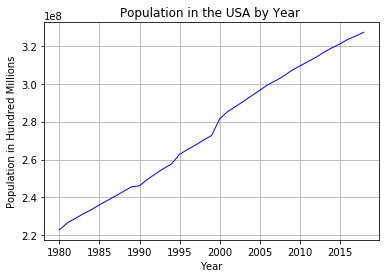

In [12]:
# Population Graph. Interesting - maybe.
# Create the plot and add a label for the legend.
plt.plot(x_axis, y_axis, color= "b", linewidth=1)
# Other options:#marker="*", color="blue", linewidth=1, label='x')
plt.xlabel("Year")
plt.ylabel("Population in Hundred Millions")
plt.title("Population in the USA by Year ")
plt.grid()

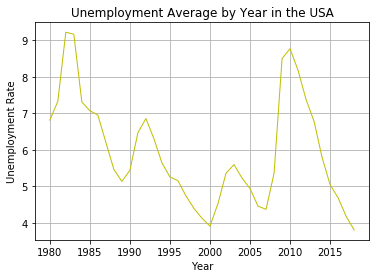

In [15]:
# Unemployment Graph
# Create the plot and add a label for the legend.
plt.plot(x_axis, emp_axis, color= "y", linewidth=1)
# Options:#marker="*", color="blue", linewidth=1, label='x')
plt.xlabel("Year")
plt.ylabel("Unemployment Rate")
plt.title("Unemployment Average by Year in the USA")
plt.grid()
#plt.legend()

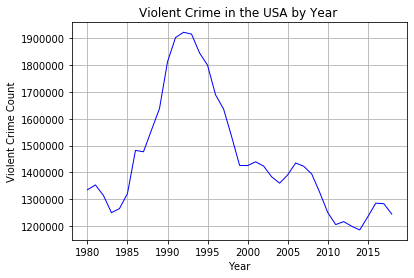

In [16]:
# Violent Crime Graph
# Create the plot and add a label for the legend.
plt.plot(x_axis, vc_axis, color= "b", linewidth=1)
# Options:#marker="*", color="blue", linewidth=1, label='x')
plt.xlabel("Year")
plt.ylabel("Violent Crime Count")
plt.title("Violent Crime in the USA by Year ")
plt.grid()

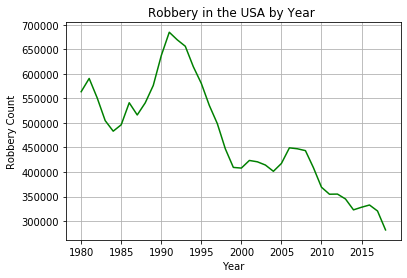

In [17]:
# Robbery Graph
plt.plot(x_axis, rc_axis, color= "g")
# Options:#marker="*", color="blue", linewidth=1, label='x')
plt.xlabel("Year")
plt.ylabel("Robbery Count")
plt.title("Robbery in the USA by Year ")
plt.grid()

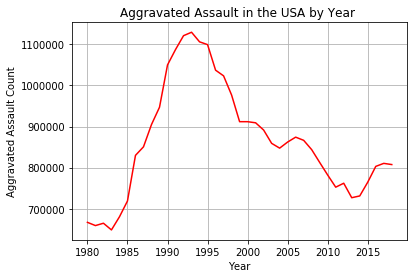

In [19]:
# Aggravated Assault Graph
# Create the plot and add a label for the legend.
plt.plot(x_axis, ag_axis, color= "r")
# Options:#marker="*", color="blue", linewidth=1, label='x')
plt.xlabel("Year")
plt.ylabel("Aggravated Assault Count")
plt.title("Aggravated Assault in the USA by Year ")
plt.grid()

#### Create two presentation charts.

<function matplotlib.pyplot.show(*args, **kw)>

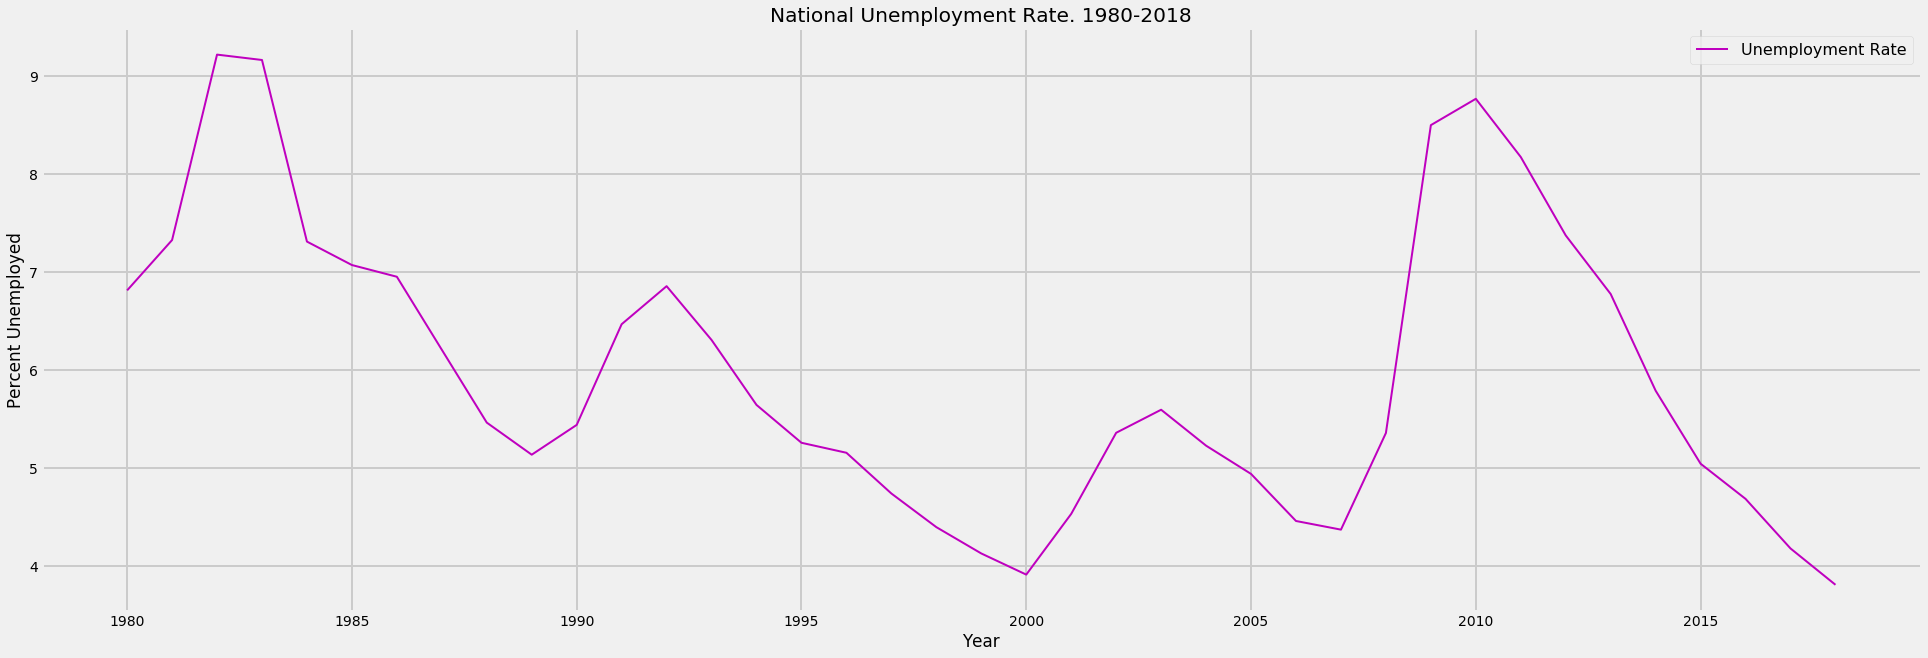

In [64]:
## Plot the Unemployment Chart.

# control the size
fig, ax = plt.subplots(figsize=(30, 10))

ax.set_title("National Unemployment Rate. 1980-2018")

# # configure the properties and label
ax.plot(x_axis, emp_axis, color="m",linewidth=2, label = "Unemployment Rate")

#ax.legend()
lgnd = plt.legend(fontsize="16"
             , scatterpoints=1 # number of markers in the legend. nice fine continous line.
             , loc="upper right")  # place legend in center 
lgnd.legendHandles[0]._sizes = [100] # sets legend handles to 100
lgnd.get_title().set_fontsize(14) # legend title size
lgnd.get_title().set_weight="bold" # bold the legend title

# # Label the axis
ax.set_xlabel("Year")
ax.set_ylabel("Percent Unemployed")

# # Set the x limit between January and June
# #ax.set_xlim(0,5)
# # Set the Y limit between 0 and 45
# #ax.set_ylim(0,45)
 
# # add a grid and legend
#ax.legend()
ax.grid(linewidth=2) 

#  save the figure to drive.
plt.savefig("../Images/EDA-UnemploymentRateSummary.png")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

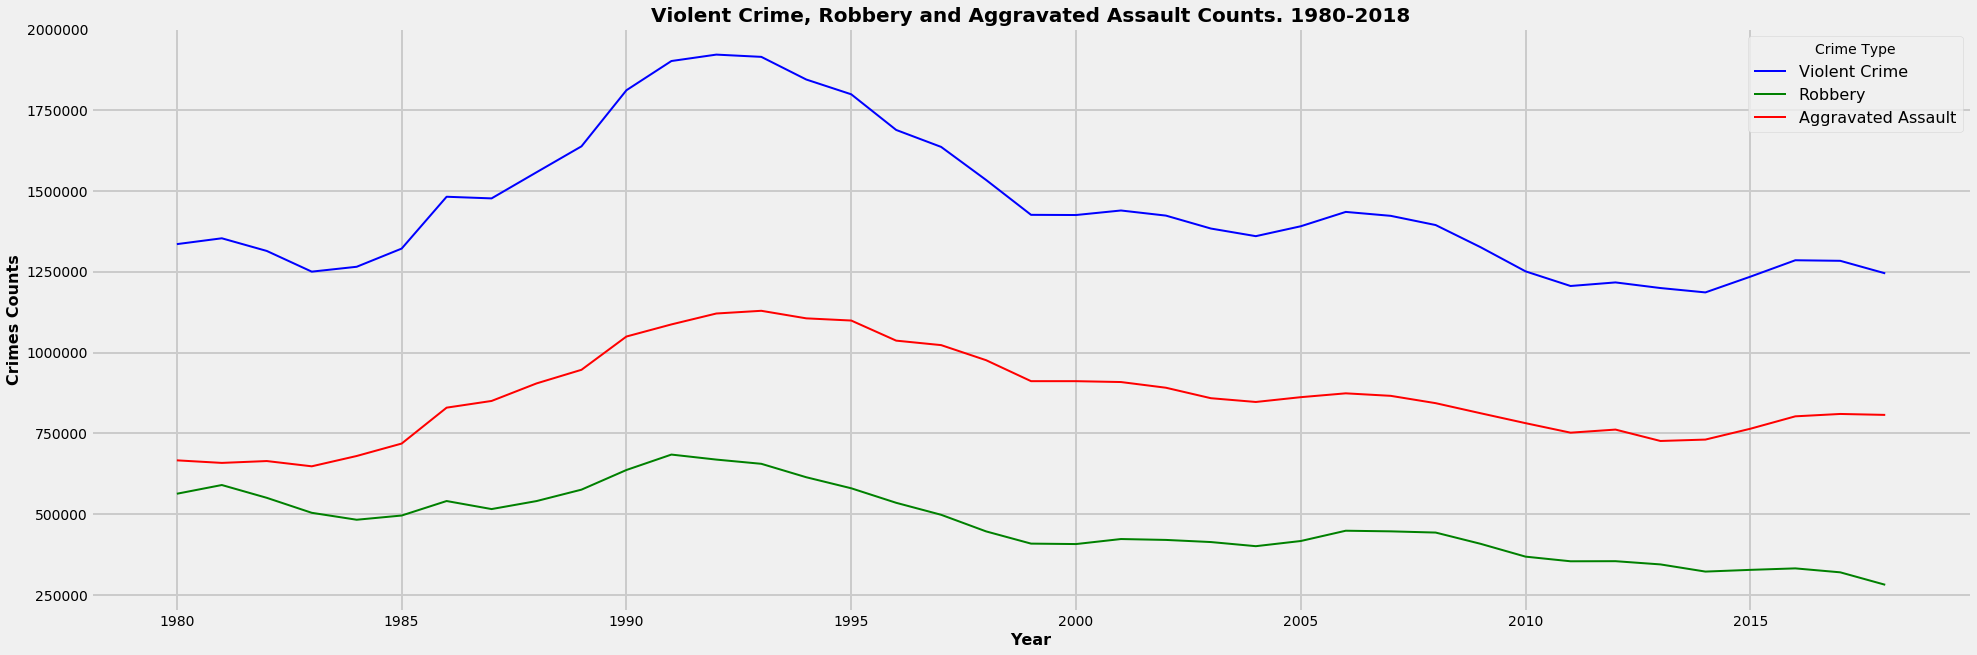

In [65]:
## Create a combined plot of the three crimes we are studying.
plt.style.use('fivethirtyeight') # figure style per requirement

fig, ax = plt.subplots(figsize=(30, 10))  ## calls object_oriented method and sets  nice diagonal size

## Build the plot
#ax.plot(x_axis, emp_axis, color="yellow", linewidth=2, label="Unemployment") 
ax.plot(x_axis, vc_axis, color="blue", linewidth=2, label="Violent Crime") 
ax.plot(x_axis, rc_axis, color="green", linewidth=2, label="Robbery")
ax.plot(x_axis, ag_axis, color="red", linewidth=2, label="Aggravated Assault")


# #Set a title
ax.set_title("Violent Crime, Robbery and Aggravated Assault Counts. 1980-2018", fontsize=20, weight="bold")

# # Label the axes
ax.set_xlabel("Year", fontsize=16, weight='bold')
ax.set_ylabel("Crimes Counts", fontsize=16, weight='bold')

## Legend parameters

# sets lgnd as variable for plt.legend() with these parameters.
lgnd = plt.legend(fontsize="16"
             , scatterpoints=1 # number of markers in the legend. nice fine continous line.
             , loc="upper right"  # place legend in center
             , title="Crime Type") # legend title
lgnd.legendHandles[0]._sizes = [100] # sets legend handles to 100
lgnd.legendHandles[1]._sizes = [100] # and so on for 2nd item.
lgnd.legendHandles[2]._sizes = [100] # and so on.
lgnd.get_title().set_fontsize(14) # legend title size
lgnd.get_title().set_weight="bold" # bold the legend title

# Setting grid, with a visible linewidth
ax.grid(linewidth=2) 

##  save the figure to drive.
plt.savefig("../Images/EDA-Crimes_Of_Interest_CountsbyYear.png")

### show me the dream!!!
plt.show

In [53]:
## Export to a CSV.
crimes_employment = "../Resources/CleanedData/CrimeAndEmploymentByYear.csv"
CrimesEmploymentByYear_df.to_csv(crimes_employment, index=False)